# Build an autonomous multi-agents workflow to write picture book
## Part 2

- Workflow_2 - Write story sections in parallel
- In this step, we will create two agents: "cartoonist" and "editor", to write story chapters.
- The cartoonist creates an initial draft for each chapter according to the outline created in the last step. Then, the editor will review the draft and provide suggestions for the cartoonist to revise the chapter.
- Generate a json file named "story.json"
- 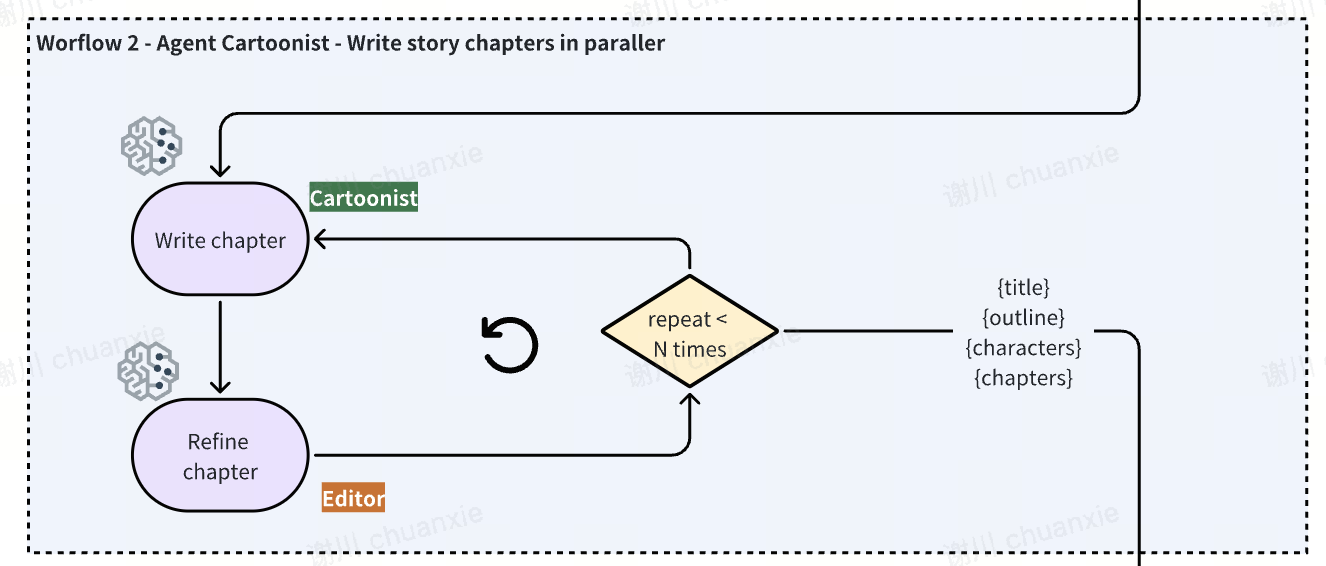 

## 1. Install dependecies

In [ ]:
%pip install -Uq langchain_community==0.2.12 langgraph==0.2.14 langchain-aws==0.1.17 langchain_core==0.2.35 

## 2.Prerequisites code

### 2.1 Import Utils functions
- In our case, we need to parse the LLM output to a pydantic object, so will define Structrued Output parser

In [ ]:
from story_agents.llm_utils import CustJsonOuputParser,TextOuputParser,dict_to_obj

- we need to reconstruct the messages send to LLM strictly follow the turns ["user","assistant"]

In [ ]:
from story_agents.llm_utils import convert_message_name,reconstruct_to_claude_messages,swap_roles

### 2.2 LLM models

In [ ]:
from langchain_aws import ChatBedrock
from langchain_core.output_parsers import StrOutputParser
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm_mistral = ChatBedrock(model_id="mistral.mistral-large-2407-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "max_tokens": 4096,
                               },
                  streaming=False,
                )

llm = llm_mistral

## 3 Agent Roles settings

- In this step, we will create two agents "cartoonist" and "editor", to write story chapters.
- The cartoonist create an initial draft for each chapter according to the outline created by last step, then editor will review the draft, and provide suggestions for cartoonist to revise the chatper

In [ ]:
#set background information
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world.\n"""

In [ ]:
role_config = {
"cartoonist":  
      company_setting+"""You are a cartoonist.
Your task is to write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible.
You can refine your story if there is suggestion provided by other roles in your studio 
      """,
    

"editor": 
      company_setting+"""You are a comics book editor, you can proofread and provide suggestions on improving the content of Plot design of the book.
Here is outline of a comics book: 
<outline>
{outline}
</outline>
You are now required to proofread and provide suggestions on specific chapter based on the outline, with the following aspects:
<aspects>
  1. it should consider the context of other chapters in the outline to continue writing your specific chapter
  2. it should consider contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
  3. it should consider topics such as pornography, racial discrimination, and toxic content
  4. it should be compelling and attract young people
  4. Any other suggestions which you think can improve the content
</aspects>
"""
}

## 4.Create Prompts template and Chains

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional,Any
from story_agents.structure_objects import Outline, Character

### 4.1 Story object consists of chapters, images and title
- each chapter consist of several paragrahs
- 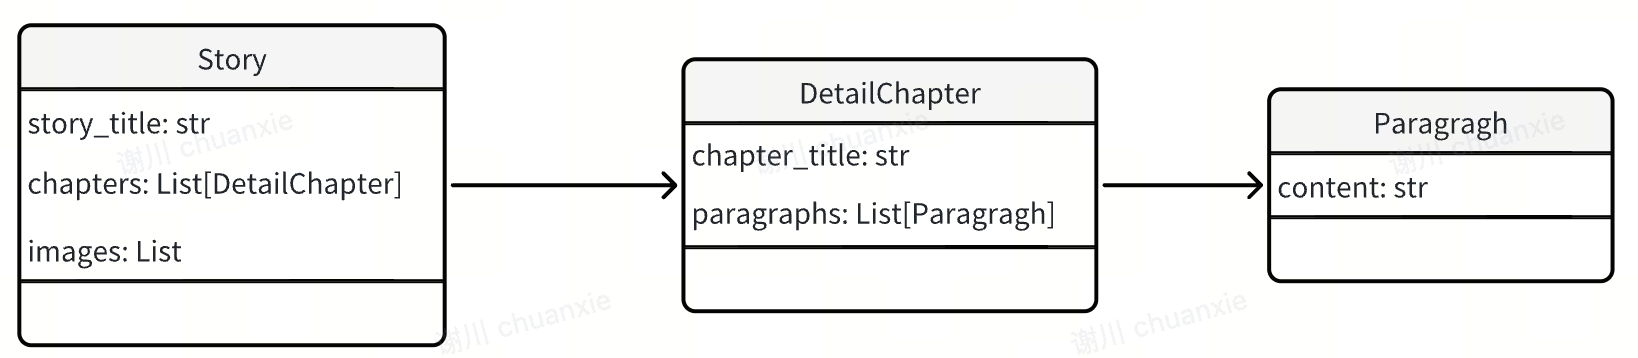

In [ ]:
class DetailChapter(BaseModel):
    """
        Content of the Chapter
    """
    chapter_title: str = Field(..., description="Title of the chapter")
    content: str = Field(..., description="Content of the chapter")
    
    @property
    def as_str(self) -> str:
        return f"## {self.chapter_title}\n\n{self.content}".strip()
    
class EditorSuggestion(BaseModel):
    """
        editor's suggestions, max 10 is allowed
    """
    suggestions: List[str] = Field(
      description="suggestion list",
      max_items=8,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([f"{i+1}.{e}" for i,e in enumerate(self.suggestions)])


class Story(BaseModel):
    """
        the full story object
    """
    story_title: str = Field(..., title="Title of the comics book")
    chapters: List[DetailChapter] = Field(
        default_factory=list,
        description="each chapter of the comics book. limits to maximum 5 items",
    )
    images: Optional[List[Any]] = Field(default=[], title="List of illustration for each chapter")
    
    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.story_title}\n\n{chapter}".strip()

### 4.3 Prompt template for write chapter and review

In [ ]:
from story_agents.prompts import fc_desc
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

write_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["cartoonist"]  + 
         """Here is the outline of the story: 
      <outline>
      {outline}
      </outline>
      Here is the characters of the story:
      <characters>
      {characters}
      </characters>
      You are now required to write stories for specific chapter based on the outline and characters, with the following requirements:
      <requirements>
        1. You need to consider the context of other chapters in the outline to continue writing your specific chapter
        2. You can only use the characters to write the story, don't create any other characters beyond the provided characters.
        3. Avoid contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
        4. Avoid topics such as pornography, racial discrimination, and toxic content
      </requirements>""" + fc_desc
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ]
)

In [ ]:
review_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["editor"],
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ])

## 5 Build workflow graph

### 5.1 define node functions

In [ ]:
from story_agents.graph_utils import AgentState, retry_call,get_final_state_env_var
from langgraph.graph import StateGraph, END

async def write_chapter(state: AgentState):
    """
    write chapter based on given outline and characters

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
        
    messages = state["messages"]
    name = 'cartoonist'
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    characters = env_var['characters']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    assert not outline == None
    gen_chapter_chain = write_chapter_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
    chapter_obj= await retry_call(gen_chapter_chain,{"outline":outline.json(),"messages":messages,"characters":characters.as_str,"schema":DetailChapter.schema_json()})
    
    
    ## sometimes the agent would end the converastion, so it would not follow the structured output. we should end converastion then
    if isinstance(chapter_obj,DetailChapter):
        formatted_message = AIMessage(name=name, content=chapter_obj.json())
        return {"messages":[formatted_message],"env_var":{**env_var,"chapter":chapter_obj}}
    else:
        return {"messages":[AIMessage(name=name, content="Let's end the coversation")],"env_var":{**env_var}}
    

In [ ]:
async def refine_chapter(state: AgentState):
    """
    refine chapter based on given outline

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
        
    messages = state["messages"]
    name = "editor"
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    refine_chapter_chain = review_chapter_prompt | llm | StrOutputParser()
    # suggestion = await refine_chapter_chain.ainvoke({"outline":outline,"messages":messages})
    suggestion = await retry_call(refine_chapter_chain,{"outline":outline.json(),"messages":messages})
    formatted_message = AIMessage(name=name, content=suggestion)
    return {"messages":[formatted_message],"env_var":{**env_var}}
    

In [ ]:
MAX_TURNS = 2
def should_repeat_write(state: AgentState):
    messages = state['messages']
    last_msg = messages[-1].content
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print(f'num_responses:{num_responses}')
    if num_responses > MAX_TURNS or last_msg.startswith("Let's end the coversation"):
        return 'end'
    else:
        return 'refine_chapter'

In [ ]:
write_graph = StateGraph(AgentState)

write_graph.add_node("write_chapter",write_chapter)
write_graph.add_node("refine_chapter",refine_chapter)
write_graph.set_entry_point("write_chapter")

write_graph.add_edge("refine_chapter","write_chapter")
write_graph.add_conditional_edges("write_chapter",
                                  should_repeat_write,
                                  {
                                      "end":END,
                                      "refine_chapter":"refine_chapter"
                                  })
write_workflow = write_graph.compile()

In [ ]:
from IPython.display import Image

Image(write_workflow.get_graph().draw_mermaid_png())

#### let's test run - write a single chapter
- we use the outline and characters created in last challenge

In [ ]:
from story_agents.structure_objects import Outline, Character

#### Here you need to load the json files created from last notebook

- Input the outline description file created from previous step
-  Check for Clue 1 if you want to see an example

In [ ]:
outline_filename = input()

- Input the characters description file created from previous step

In [ ]:
characters_filename = input()

In [ ]:
import json
# read the json file and parse to object
with open(outline_filename,'r') as f:
    outline_json = json.load(f)
outline = Outline.parse_obj(outline_json)

with open(characters_filename,'r') as f:
    characters_json = json.load(f)
characters = Character.parse_obj(characters_json)

- Let's write one chapter for test

In [ ]:
steps = []
init_state = {
    "env_var":{"outline":outline,"characters":characters},
    "messages":[HumanMessage(content=f"Here is the origin content: {outline.chapters[0].json()}",name='editor')]
}
async for event in write_workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

In [ ]:
print(get_final_state_env_var(steps,'write_chapter')['chapter'])

#### let's use batch function to write all chapters

In [ ]:
async def write_all_chapters(chaps,outline,characters):
    init_state = {
    "env_var":{"outline":outline,"characters":characters,"chapter":None},
    "messages":[HumanMessage(content=f"Here is the origin content:\n {chaps.json()}",name='editor')]
    }       
    steps = []
    async for event in write_workflow.astream(input=init_state):
        steps.append(event)
        for key, value in event.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    ret = get_final_state_env_var(steps,'write_chapter')['chapter']
    # trans =  get_final_state_env_var(steps,'translate_chapter')['translation']
    return (ret,None)

In [ ]:
chaps = [ chatper for chatper in  outline.chapters]

#### Running in parallel
- We will parse the output to structured json object, if you encounter JSONDecodeError, you can re-run it

In [ ]:
write_all = RunnableLambda(write_all_chapters).bind(outline=outline,characters=characters)
all_steps =  await write_all.abatch(chaps)

### 5.3 merge all Subchapters together

In [ ]:
story = Story(story_title=outline.page_title,chapters=[s[0] for s in all_steps])
print(len(story.as_str))
print(story.as_str)

#### Save to local files

In [ ]:
with open('story.json','w') as f:
    f.write(story.json())

### 6.In the file browser Panel, open the 'story.json' with text editor, then copy and paste to the answer box in the JAM Task.